# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/BCG DS/data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,...,71,9,1,0,0,0,0,1,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 63 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   id                                          14606 non-null  object 
 1   cons_12m                                    14606 non-null  float64
 2   cons_gas_12m                                14606 non-null  float64
 3   cons_last_month                             14606 non-null  float64
 4   forecast_cons_12m                           14606 non-null  float64
 5   forecast_discount_energy                    14606 non-null  float64
 6   forecast_meter_rent_12m                     14606 non-null  float64
 7   forecast_price_energy_off_peak              14606 non-null  float64
 8   forecast_price_energy_peak                  14606 non-null  float64
 9   forecast_price_pow_off_peak                 14606 non-null  float64
 10  has_gas   

---

## 3. Modelling

We now have a dataset containing features that we have engineered and we are ready to start training a predictive model. Remember, we only need to focus on training a `Random Forest` classifier.

### Data sampling

The first thing we want to do is split our dataset into training and test samples. The reason why we do this, is so that we can simulate a real life situation by generating predictions for our test sample, without showing the predictive model these data points. This gives us the ability to see how well our model is able to generalise to new data, which is critical.

A typical % to dedicate to testing is between 20-30, for this example we will use a 75-25% split between train and test respectively.

In [6]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training

Once again, we are using a `Random Forest` classifier in this example. A Random Forest sits within the category of `ensemble` algorithms because internally the `Forest` refers to a collection of `Decision Trees` which are tree-based learning algorithms. As the data scientist, you can control how large the forest is (that is, how many decision trees you want to include).

The reason why an `ensemble` algorithm is powerful is because of the laws of averaging, weak learners and the central limit theorem. If we take a single decision tree and give it a sample of data and some parameters, it will learn patterns from the data. It may be overfit or it may be underfit, but that is now our only hope, that single algorithm.

With `ensemble` methods, instead of banking on 1 single trained model, we can train 1000's of decision trees, all using different splits of the data and learning different patterns. It would be like asking 1000 people to all learn how to code. You would end up with 1000 people with different answers, methods and styles! The weak learner notion applies here too, it has been found that if you train your learners not to overfit, but to learn weak patterns within the data and you have a lot of these weak learners, together they come together to form a highly predictive pool of knowledge! This is a real life application of many brains are better than 1.

Now instead of relying on 1 single decision tree for prediction, the random forest puts it to the overall views of the entire collection of decision trees. Some ensemble algorithms using a voting approach to decide which prediction is best, others using averaging.

As we increase the number of learners, the idea is that the random forest's performance should converge to its best possible solution.

Some additional advantages of the random forest classifier include:

- The random forest uses a rule-based approach instead of a distance calculation and so features do not need to be scaled
- It is able to handle non-linear parameters better than linear based models

On the flip side, some disadvantages of the random forest classifier include:

- The computational power needed to train a random forest on a large dataset is high, since we need to build a whole ensemble of estimators.
- Training time can be longer due to the increased complexity and size of thee ensemble

In [10]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)
X_std = scaler.transform(X)

In [11]:
stay = (y_train.value_counts()[0] / y_train.shape)[0]
leave = (y_train.value_counts()[1] / y_train.shape)[0]

print("===============TRAIN=================")
print(f"Staying Rate: {stay * 100:.2f}%")
print(f"Leaving Rate: {leave * 100 :.2f}%")

stay = (y_test.value_counts()[0] / y_test.shape)[0]
leave = (y_test.value_counts()[1] / y_test.shape)[0]

print("===============TEST=================")
print(f"Staying Rate: {stay * 100:.2f}%")
print(f"Leaving Rate: {leave * 100 :.2f}%")


===============TRAIN=================
Staying Rate: 90.39%
Leaving Rate: 9.61%
===============TEST=================
Staying Rate: 89.98%
Leaving Rate: 10.02%


we have a highly imbalanced datasets,to deal  with this there are a couple of ways to handle this:oversampling,undersampling,ensembling or subsampling.I only want to use real data so I will use the ensembling method.
-Givn how imbalanced the dataset is,I won't focus on accuracy,let me use the roc-auc score to do my model evaluation.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Balanced Random Forest AUC score: 0.6877329024925125
Classification Report for Balanced Random Forest:

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3286
           1       0.71      0.08      0.15       366

    accuracy                           0.90      3652
   macro avg       0.81      0.54      0.55      3652
weighted avg       0.89      0.90      0.87      3652

--------------------------------------------------------------------------------
Logistic Regression AUC score: 0.658044951378272
Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      3286
           1       0.14      0.56      0.22       366

    accuracy                           0.60      3652
   macro avg       0.53      0.58      0.47      3652
weighted avg       0.85      0.60      0.68      3652

----------------------------------------------------------------

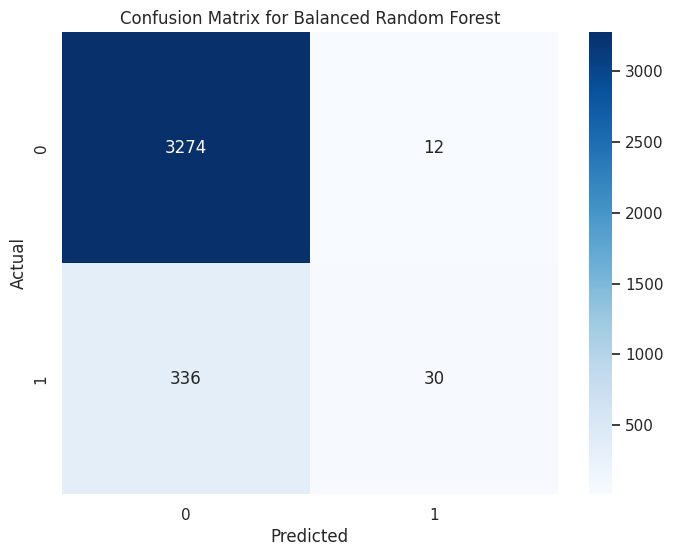

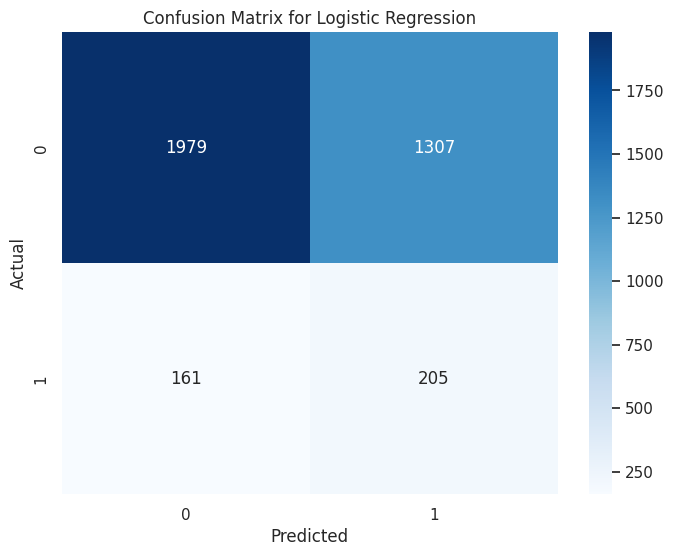

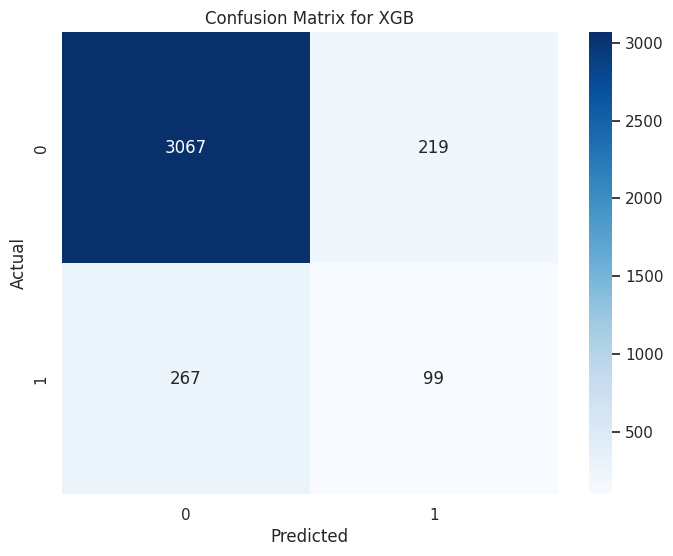

In [15]:
#ENSEMLED MODELS
models = {
    'Balanced Random Forest': RandomForestClassifier(random_state=42,bootstrap=False,class_weight='balanced'),
    'Logistic Regression': LogisticRegression(max_iter=1000,class_weight='balanced'),
    'XGB': XGBClassifier(scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]))
}

# Stratified K-Fold for evaluation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store AUC scores for each model
scores_dict_ensemble = {}

# Store classification reports for each model
classification_reports = {}

# Evaluate each model using Stratified K-Fold
for model_name, model in models.items():
    auc_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        # Create train and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the validation set
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC for this fold
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # Average AUC across all folds
    scores_dict_ensemble[model_name] = sum(auc_scores) / len(auc_scores)

    # Train the model on the full training set and get classification report
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    classification_reports[model_name] = classification_report(y_test, y_pred)

# Print model performance and classification reports
for model_name, score in scores_dict_ensemble.items():
    print(f'{model_name} AUC score: {score}')
    print(f'Classification Report for {model_name}:\n')
    print(classification_reports[model_name])
    print('-' * 80)

#Plot confusion matrices for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()





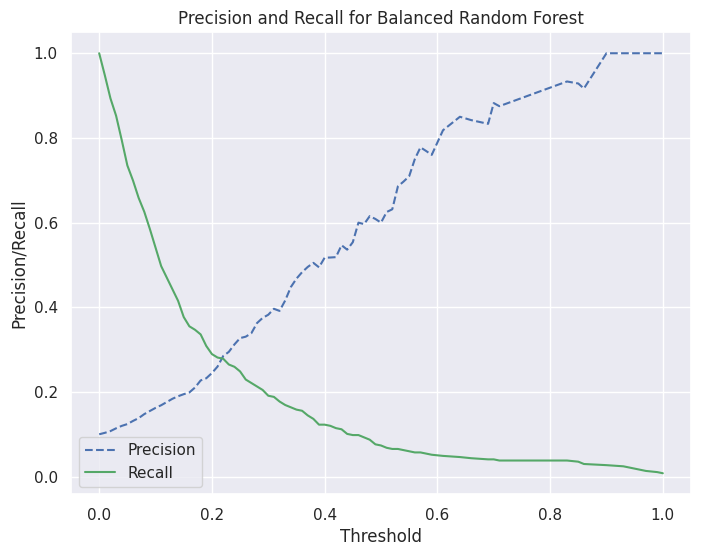

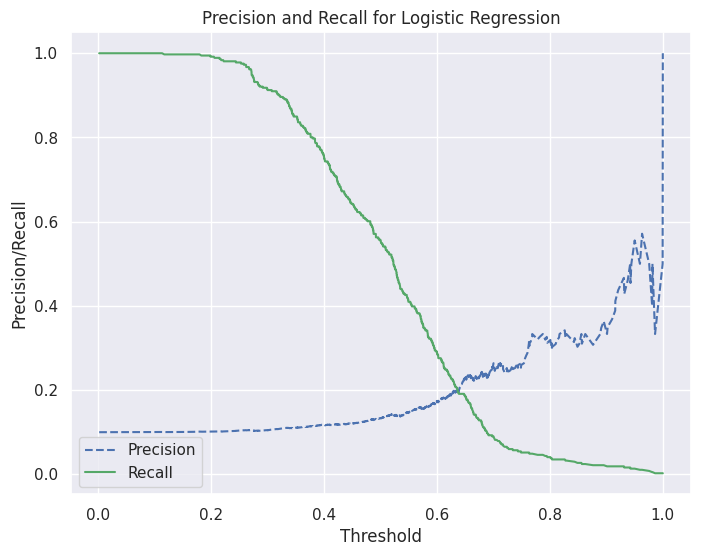

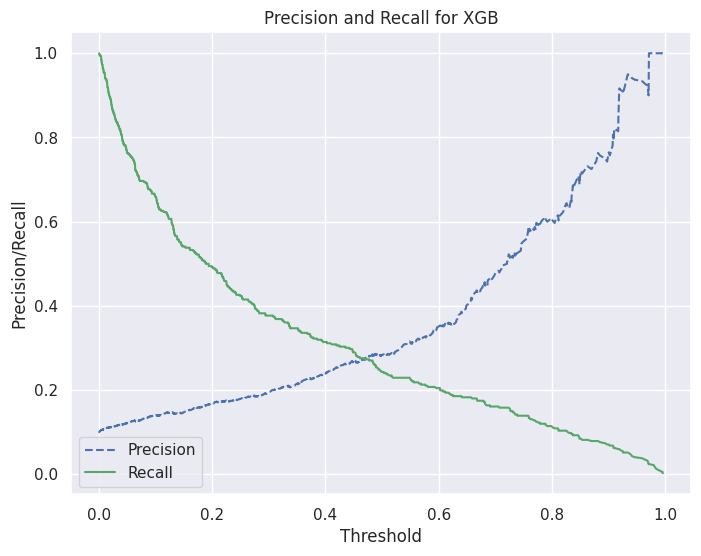

In [17]:
# Plot threshold vs precision and recall for each model
for model_name, model in models.items():
    # Train the model on the full training set
    model.fit(X_train_std, y_train)

    # Predict probabilities on the test set
    y_pred_proba = model.predict_proba(X_test_std)[:, 1]

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Plot precision and recall as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.title(f'Precision and Recall for {model_name}')
    plt.legend(loc='best')
    plt.show()

The precision-recall curve provides insights into the performance of a churn prediction model across various thresholds. By examining this curve, we can determine the optimal threshold at which a customer is most accurately classified as churn, balancing the trade-off between precision (the proportion of true churn predictions out of all churn predictions) and recall (the proportion of actual churners correctly identified).

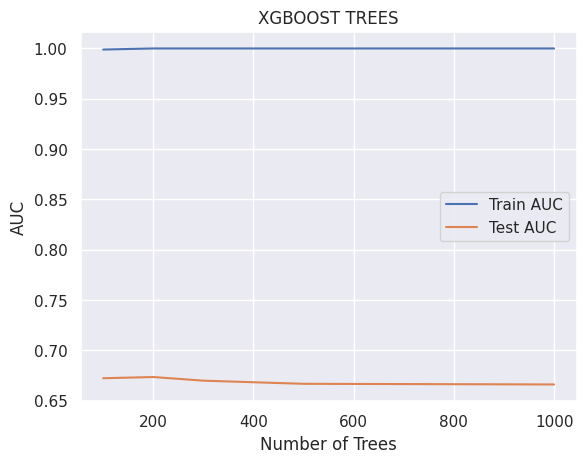

In [18]:
# Define the model
model = XGBClassifier(random_state=42)

# Arrays to store results
train_results = []
test_results = []

# Evaluate the model with different numbers of trees
for n in [100, 200, 300, 500, 1000]:
    model.set_params(n_estimators=n)
    model.fit(X_train_std, y_train)

    train_pred = model.predict_proba(X_train_std)[:, 1]
    test_pred = model.predict_proba(X_test_std)[:, 1]

    train_results.append(roc_auc_score(y_train, train_pred))
    test_results.append(roc_auc_score(y_test, test_pred))

# Plot the results
plt.plot([100, 200, 300, 500, 1000], train_results, label='Train AUC')
plt.plot([100, 200, 300, 500, 1000], test_results, label='Test AUC')
plt.xlabel('Number of Trees')
plt.title('XGBOOST TREES')
plt.ylabel('AUC')
plt.legend()
plt.show()

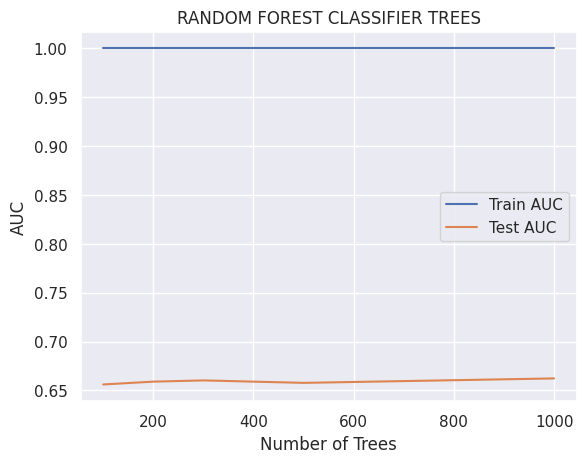

In [19]:
# Define the model
model = RandomForestClassifier(random_state=42)

# Arrays to store results
train_results = []
test_results = []

# Evaluate the model with different numbers of trees
for n in [100, 200, 300, 500, 1000]:
    model.set_params(n_estimators=n)
    model.fit(X_train_std, y_train)

    train_pred = model.predict_proba(X_train_std)[:, 1]
    test_pred = model.predict_proba(X_test_std)[:, 1]

    train_results.append(roc_auc_score(y_train, train_pred))
    test_results.append(roc_auc_score(y_test, test_pred))

# Plot the results
plt.plot([100, 200, 300, 500, 1000], train_results, label='Train AUC')
plt.plot([100, 200, 300, 500, 1000], test_results, label='Test AUC')
plt.xlabel('Number of Trees')
plt.ylabel('AUC')
plt.title('RANDOM FOREST CLASSIFIER TREES')
plt.legend()
plt.show()


True positives: 20
False positives: 3
True negatives: 3283
False negatives: 346

Accuracy: 0.9044359255202629
Precision: 0.8695652173913043
Recall: 0.0546448087431694

Classification Report:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3286
           1       0.87      0.05      0.10       366

    accuracy                           0.90      3652
   macro avg       0.89      0.53      0.53      3652
weighted avg       0.90      0.90      0.86      3652

[[3283    3]
 [ 346   20]]


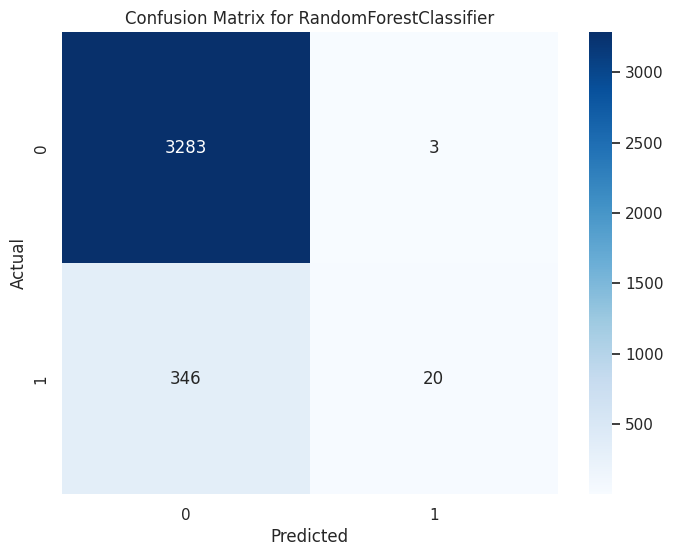

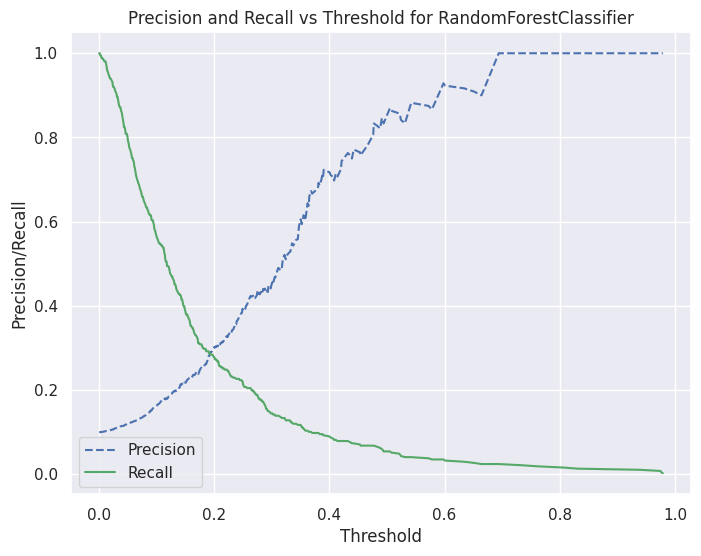

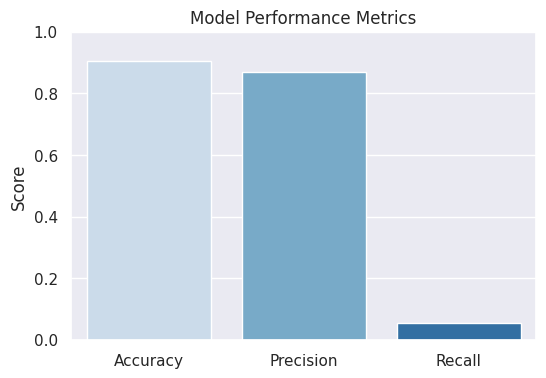

In [47]:
model = RandomForestClassifier(
    n_estimators=1000,
    class_weight='balanced',
    random_state=42,

)
model.fit(X_train, y_train)
# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # For precision-recall curve

# Confusion matrix and metrics
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix for RandomForestClassifier')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
  # plt.show()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Plot threshold vs precision and recall
pr_precision, pr_recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, pr_precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, pr_recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall vs Threshold for RandomForestClassifier')
plt.legend(loc='best')
plt.show()

# Plot metrics bar plot
plt.figure(figsize=(6, 4))
metrics_names = ['Accuracy', 'Precision', 'Recall']
metrics_scores = [accuracy, precision, recall]
sns.barplot(x=metrics_names, y=metrics_scores, palette='Blues')
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

In [33]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# Try BalancedBaggingClassifier
brf = BalancedBaggingClassifier(
    # Changed base_estimator to estimator
    estimator=RandomForestClassifier(
        max_depth=10,
        min_samples_leaf=5,
        min_samples_split=10,
        n_estimators=200,
        n_jobs=-1
    ),
    sampling_strategy='auto',
    replacement=False,
    random_state=42,
    n_jobs=-1
)

# Fit and evaluate
brf.fit(X_train, y_train)
y_pred = brf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      0.74      0.82      3286
           1       0.17      0.49      0.25       366

    accuracy                           0.71      3652
   macro avg       0.55      0.61      0.54      3652
weighted avg       0.85      0.71      0.76      3652



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Balanced Random Forest AUC score: 0.6864
Classification Report for Balanced Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3286
           1       0.26      0.28      0.27       366

    accuracy                           0.85      3652
   macro avg       0.59      0.60      0.59      3652
weighted avg       0.85      0.85      0.85      3652

--------------------------------------------------------------------------------
Logistic Regression AUC score: 0.6581
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.60      0.73      3286
           1       0.14      0.56      0.22       366

    accuracy                           0.60      3652
   macro avg       0.53      0.58      0.47      3652
weighted avg       0.85      0.60      0.68      3652

--------------------------------------------------------------------------------
XGB AUC 

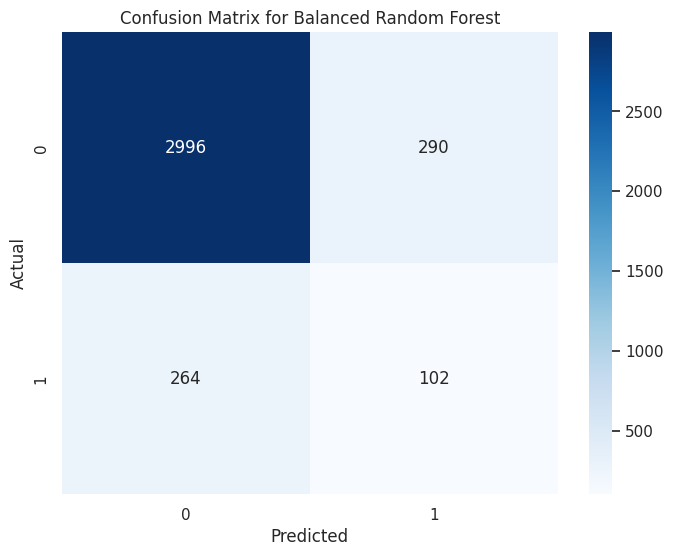

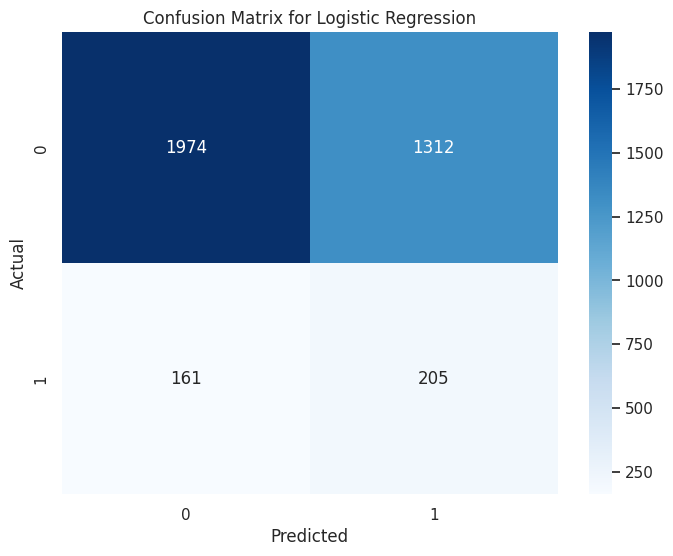

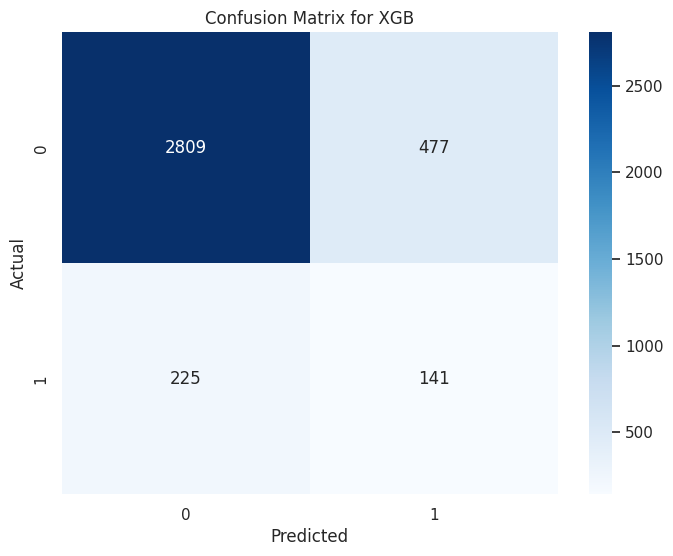

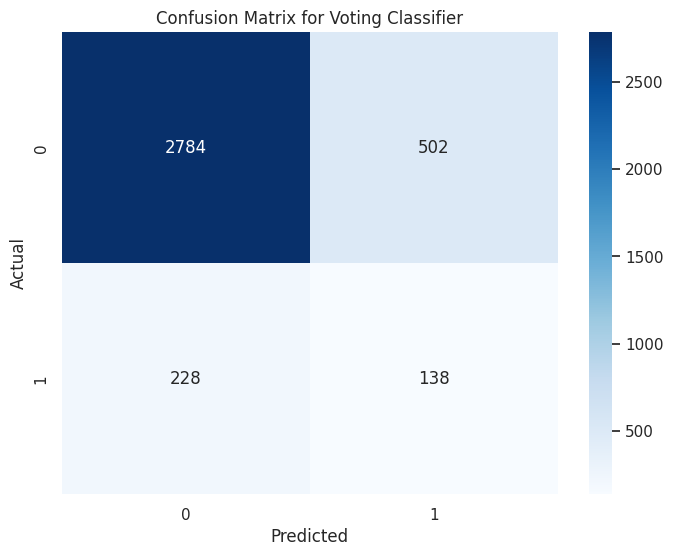

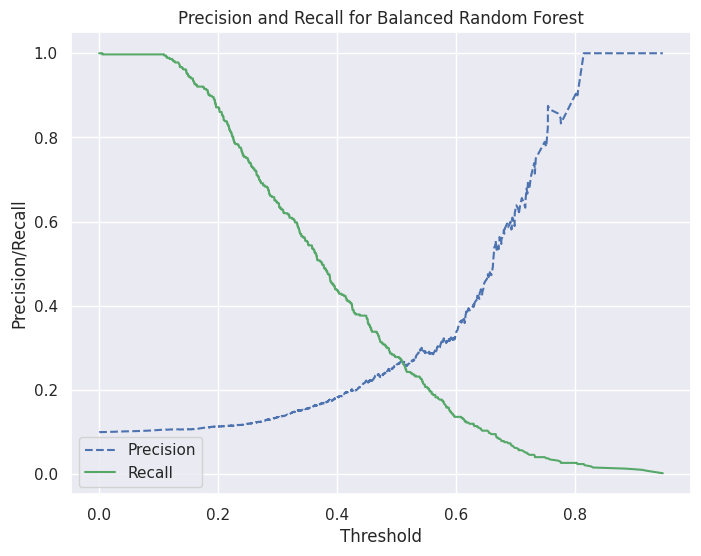

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


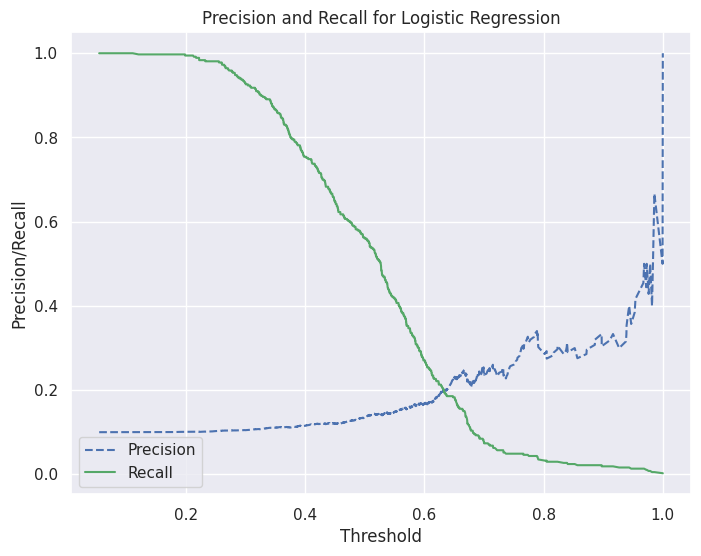

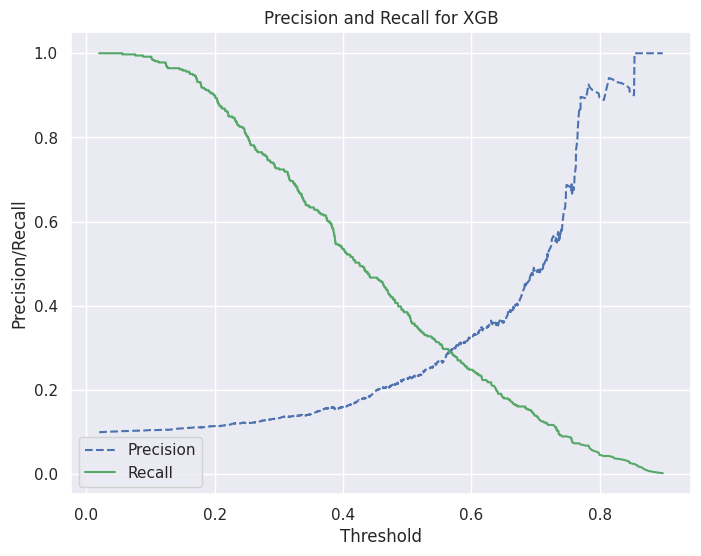

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


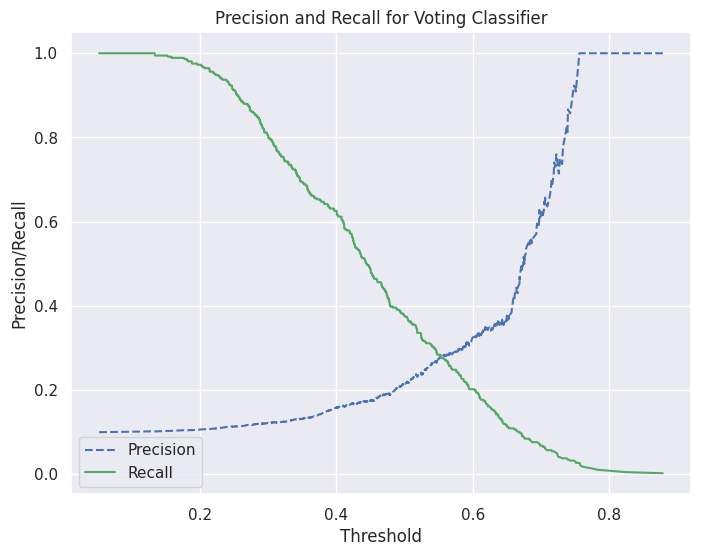

In [26]:
#Define the models with the given hyperparameters
models = {
    'Balanced Random Forest': RandomForestClassifier(
        random_state=42, bootstrap=False,
        max_depth=12, min_samples_leaf=1, min_samples_split=2, n_estimators=500,class_weight='balanced'
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000, C=0.1, penalty='l2', solver='lbfgs', class_weight='balanced'
    ),
    'XGB': XGBClassifier(
        learning_rate=0.01, max_depth=8, n_estimators=300,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
    )
}

# Define a VotingClassifier with 'soft' voting (using probabilities)
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'
)

# Add the Voting Classifier to the models dictionary
models['Voting Classifier'] = voting_clf

# Stratified K-Fold for evaluation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Store AUC scores for each model
scores_dict_ensemble = {}

# Store classification reports for each model
classification_reports = {}

# Evaluate each model using Stratified K-Fold
for model_name, model in models.items():
    auc_scores = []
    for train_idx, val_idx in kf.split(X_train, y_train):
        # Create train and validation sets
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Predict probabilities on the validation set
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calculate AUC for this fold
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # Average AUC across all folds
    scores_dict_ensemble[model_name] = np.mean(auc_scores)

    # Train the model on the full training set and get classification report
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    classification_reports[model_name] = classification_report(y_test, y_pred)

# Print model performance and classification reports
for model_name, score in scores_dict_ensemble.items():
    print(f'{model_name} AUC score: {score:.4f}')
    print(f'Classification Report for {model_name}:\n{classification_reports[model_name]}')
    print('-' * 80)

# Plot confusion matrices for each model
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot threshold vs precision and recall for each model
for model_name, model in models.items():
    # Train the model on the full training set
    model.fit(X_train, y_train)

    # Predict probabilities on the test set
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Plot precision and recall as a function of the threshold
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Precision/Recall')
    plt.title(f'Precision and Recall for {model_name}')
    plt.legend(loc='best')
    plt.show()

Number of False Positives on the training set: 519


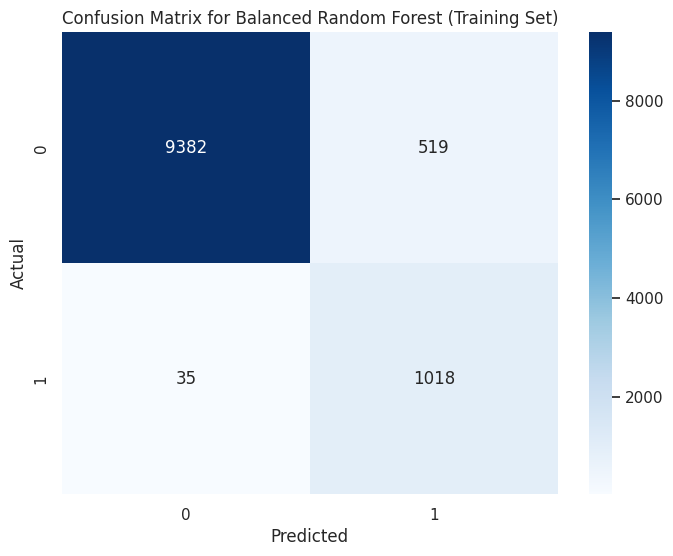

In [27]:

# Train the model on the full training set
rf_model = models['Balanced Random Forest']
rf_model.fit(X_train, y_train)

# Predict on the training set
y_train_pred = rf_model.predict(X_train)

# Generate confusion matrix for the training set
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

# Extract False Positives from the training set confusion matrix
false_positives_train = train_conf_matrix[0, 1]
print(f"Number of False Positives on the training set: {false_positives_train}")

# Plot confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Balanced Random Forest (Training Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Number of False Positives on the test set: 290


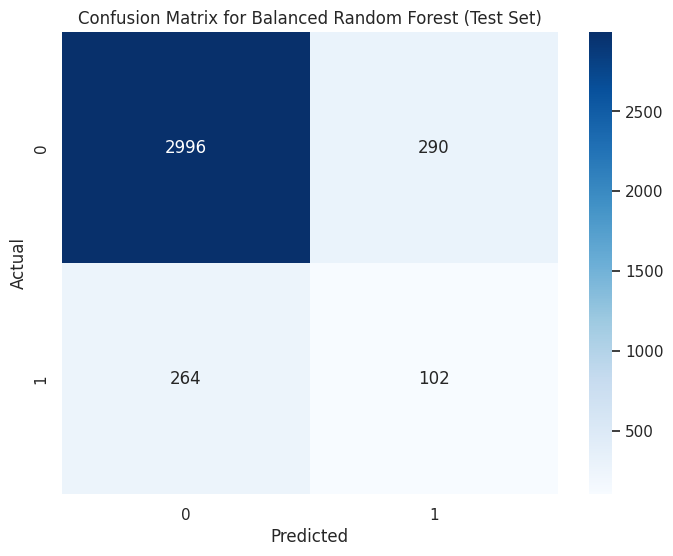

In [28]:
# Now, predict on the test set and plot the confusion matrix for the test set
y_test_pred = rf_model.predict(X_test)

# Generate confusion matrix for the test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Extract False Positives from the test set confusion matrix
false_positives_test = test_conf_matrix[0, 1]
print(f"Number of False Positives on the test set: {false_positives_test}")

# Plot confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Balanced Random Forest (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [29]:
# Get the components of the confusion matrix from the test set
# The confusion matrix is structured as follows for a binary classification problem:
# [[True Negatives (tn), False Positives (fp)],
#  [False Negatives (fn), True Positives (tp)]]
tn, fp, fn, tp = test_conf_matrix.ravel()

# Assign the predictions from the best model to 'predictions'
# Based on the previous cells, best_model was obtained from grid_search
predictions = rf_model.predict(X_test)

print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 102
False positives: 290
True negatives: 2996
False negatives: 264

Accuracy: 0.848302300109529
Precision: 0.2602040816326531
Recall: 0.2786885245901639


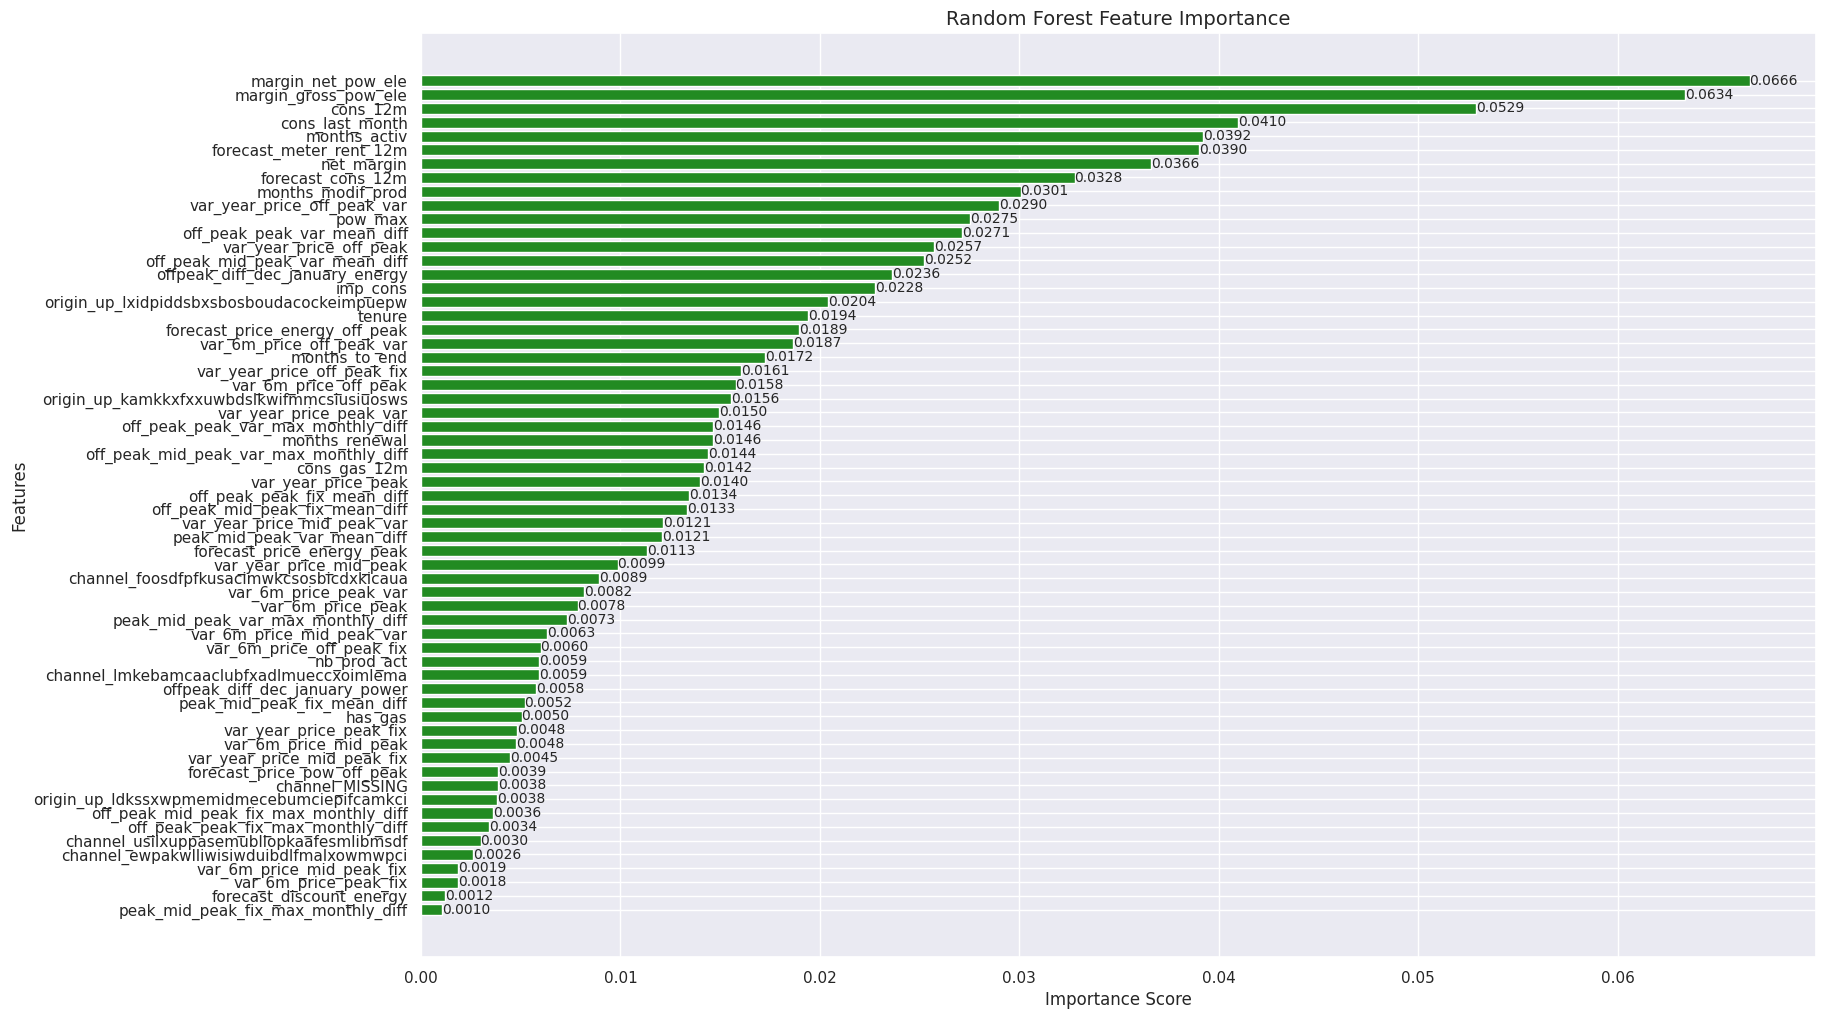

In [30]:
#RANDOM FOREST CLASSIFIER FEATURE
 # Extract the Balanced Random Forest model
rf = models['Balanced Random Forest']

# Ensure it's trained
rf.fit(X_train, y_train)

def plot_rf_feature_importance(model, feature_names):
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(18, 12))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='forestgreen')
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.title('Random Forest Feature Importance', fontsize=14)
    plt.gca().invert_yaxis()  # Highest importance at the top

    # Add annotations for importance values
    for index, value in enumerate(importance_df['Importance']):
        plt.text(value, index, f'{value:.4f}', va='center', fontsize=10)
    plt.show()

# Plot Random Forest Feature Importance
plot_rf_feature_importance(rf, X_train.columns)

Here,I was busy playing around with different methods,adjusting my hyperparameter tuning to see what works best.I honestlty had so much hope for the ensembling method,but it takes to long to train and the results are not good enough for me to stick with it.I will stick to just the balanced rando forest,In the real world ,the next step would be deplozing the model,building the pipeline and monitoring the model incase retraining was required.